# YOLOv2 物體偵測

In [77]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [50]:
import warnings
warnings.filterwarnings('ignore') # 暫時隱藏一些Warning訊息

import os
import random
import numpy as np
import platform
import tensorflow
import keras
from keras import backend as K
from keras.models import load_model
from keras.utils import plot_model

from PIL import Image, ImageDraw, ImageFont
import colorsys
import imghdr
from yad2k.models.keras_yolo import yolo_eval, yolo_head
import cv2
from tqdm import tqdm
import time
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as display

%matplotlib inline

print("Platform: {}".format(platform.platform()))
print("Tensorflow version: {}".format(tensorflow.__version__))
print("Keras version: {}".format(keras.__version__))

Platform: Darwin-17.4.0-x86_64-i386-64bit
Tensorflow version: 1.5.0
Keras version: 2.1.4


## 1. Config

In [75]:
#File Folder
model_path='model_data/yolov2_coco_608x608.h5'
anchors_path='model_data/yolov2_coco_608x608_anchors.txt'
classes_path='model_data/coco_classes.txt'
test_path='images'
output_path = 'images/out'
score_threshold=0.3
iou_threshold=0.3
if not os.path.exists(output_path):
    print('Creating output path {}'.format(output_path))
    os.mkdir(output_path)
    
# Class Name
with open(classes_path) as f:
    class_names = f.readlines()
class_names = [c.strip() for c in class_names]

# Anchors
with open(anchors_path) as f:
    anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    anchors = np.array(anchors).reshape(-1, 2)
    
#boundind box顏色
hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),colors))
random.seed(10101)  # Fixed seed for consistent colors across runs.
random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
random.seed(None)  # Reset seed to default.

#字型
font = ImageFont.truetype(font='font/FiraMono-Medium.otf', size=np.floor(3e-3 * image.size[1]+0.5).astype('int32'))

## 2. Model

In [53]:
sess = K.get_session()  # TODO: Remove dependence on Tensorflow session.
yolo_model = load_model(model_path)
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
input_image_shape = K.placeholder(shape=(2, ))
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes = yolo_eval(yolo_outputs, input_image_shape, score_threshold=score_threshold, iou_threshold=iou_threshold)



## Read Input Image

In [58]:

TEST_IMG_PATH = 'images/test2.jpg'
image = Image.open(TEST_IMG_PATH)
print("Before image resize: ", np.array(image, dtype='float32').shape)
model_image_size = yolo_model.layers[0].input_shape[1:3] 
resized_iamge = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
image_data = np.array(resized_iamge, dtype='float32') # (img_height, img_width, img_channels)
print("After image resize: ", image_data.shape)
image_data /= 255.
image_data = np.expand_dims(image_data, 0) 


Before image resize:  (1440, 2560, 3)
After image resize:  (608, 608, 3)


## 4. Inference

In [59]:

out_boxes, out_scores, out_classes = sess.run([boxes, scores, classes],
                                             feed_dict={ yolo_model.input: image_data,
                                                 input_image_shape: [image.size[1], image.size[0]],
                                                 K.learning_phase(): 0
                                             })

print("out_boxes.shape:", out_boxes.shape, out_boxes.dtype)
print("out_scores.shape:", out_scores.shape, out_scores.dtype)
print("out_classes.shape:", out_classes.shape, out_classes.dtype)

out_boxes.shape: (10, 4) float32
out_scores.shape: (10,) float32
out_classes.shape: (10,) int64


## 5. Display Bounding Box

person 0.49 (515, 418) (613, 607)
person 0.50 (948, 408) (1109, 876)
person 0.53 (0, 316) (143, 798)
person 0.56 (303, 483) (430, 759)
person 0.57 (1312, 360) (1566, 755)
person 0.57 (834, 417) (979, 693)
person 0.65 (1241, 373) (1386, 591)
umbrella 0.69 (1113, 587) (1461, 1021)
person 0.72 (181, 294) (385, 735)
person 0.84 (1794, 378) (2125, 1382)


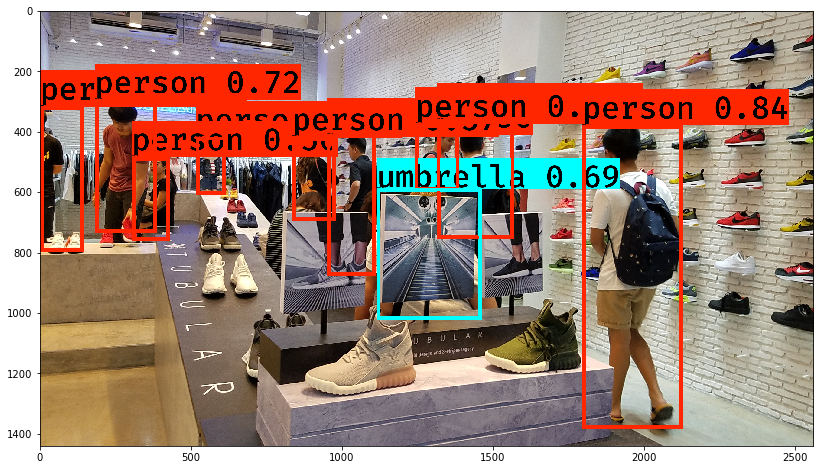

In [76]:

thickness = (image.size[0]+image.size[1]) // 400

# 迭代每個找到的物體類別
for i, c in reversed(list(enumerate(out_classes))):
    predicted_class = class_names[c]
    box = out_boxes[i]
    score = out_scores[i]
    label = '{} {:.2f}'.format(predicted_class, score)
    draw = ImageDraw.Draw(image) 
    label_size = draw.textsize(label, font) # 將"物體類別"與"信心分數"以文字的方式展現
    
    # "邊界框"的座標
    top, left, bottom, right = box
    top = max(0, np.floor(top + 0.5).astype('int32'))
    left = max(0, np.floor(left + 0.5).astype('int32'))
    bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
    right = min(image.size[0], np.floor(right + 0.5).astype('int32'))

    # 打印圖像類別, 邊界框的左上角及右下角的座標
    print(label, (left, top), (right, bottom))

    if top - label_size[1] >= 0:
        text_origin = np.array([left, top - label_size[1]])
    else:
        text_origin = np.array([left, top + 1])

    
    for i in range(thickness):
        # 畫"邊界框"
        draw.rectangle(
            [left + i, top + i, right - i, bottom - i],
            outline=colors[c])
    
    # 畫一個四方型來做為文字標籤的背景
    draw.rectangle(
        [tuple(text_origin), tuple(text_origin + label_size)],
        fill=colors[c])
    
    # 把文字標籤的資訊放到圖像上
    draw.text(text_origin, label, fill=(0, 0, 0), font=font)
    
    del draw # 移除"draw"物件

# 將最後的圖像秀出來
plt.figure(figsize=(15,8)) # 設定展示圖像的大小
plt.imshow(image) # 展示
